##Design: 

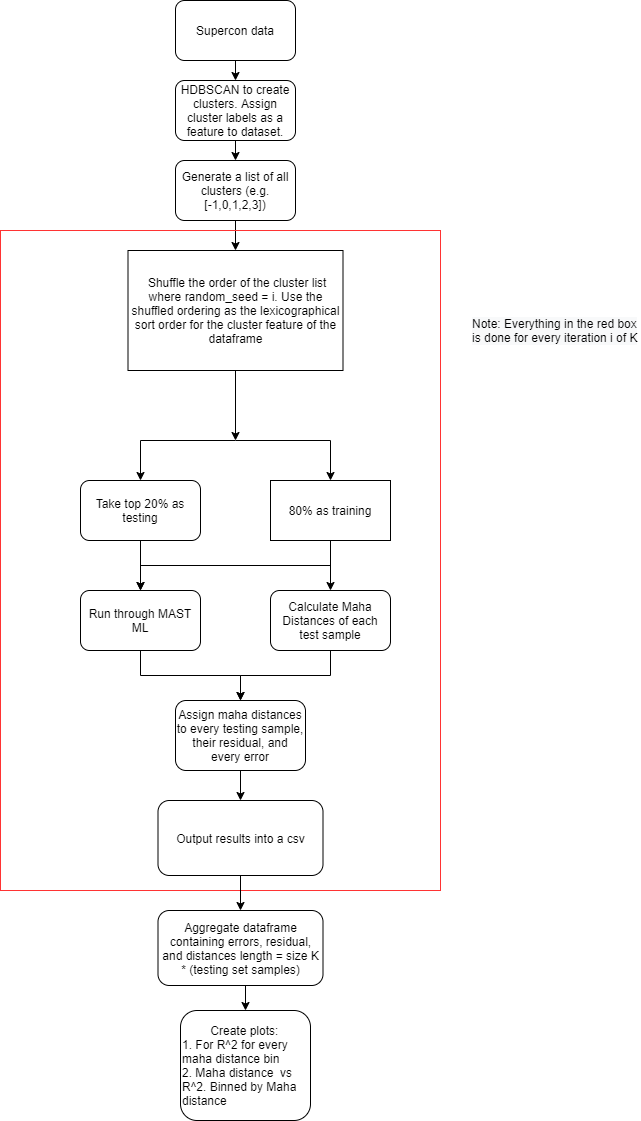

Useful articles:
https://hdbscan.readthedocs.io/en/latest/prediction_tutorial.html

In [ ]:
# MAST ML 
!git clone --single-branch --branch dev_Ryan_2020-12-21 https://github.com/uw-cmg/MAST-ML
!pip install -r MAST-ML/requirements.txt


fatal: destination path 'MAST-ML' already exists and is not an empty directory.
  Using cached hdbscan-0.8.27.tar.gz (6.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2312013 sha256=1c0e3237815f276efa3c3a5bd4fa2435ad1bdd550dda3a36172f94f0c2a1c2a6
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [ ]:
#mast ml dependencies
!pip install scikit-learn-extra
!pip install delayed

#hdbscan clustering
!pip install hdbscan

     |████████████████████████████████| 1.7 MB 31.5 MB/s 
     |████████████████████████████████| 72 kB 735 kB/s 
     |████████████████████████████████| 85 kB 5.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import scipy.linalg
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
%matplotlib inline
from collections import Counter
import hdbscan
import random
import concurrent.futures
import time

##HELPER FUNCTIONS

In [ ]:
import pandas as pd
import numpy as np
import scipy.linalg
import math
from scipy.spatial import distance

def partition_df_v2(df,
                 col,
                 partitions):
    '''
    High level - Assumes that there is a specific feature/distance metric that your dataset needs to be sorted on.
    Calculates the starting and ending indices that contain 20% of the data in the entire dataset, which will form
    y
    ----------------------------
    Args:
    df - your entire dataset
    col - column to sort on (your metric distance)
    partitions - how many partitions you want to divide your training set into. 
    
    Returns:
    sorted_df - sorted dataframe to use for your X/y in your splitter.evaluate method.
    leaveout_inds_list - the list of lists containing the indices of the test data for each partition
    '''

    try:
        sorted_df = df.sort_values(by = col, ascending=False)
    except:
        raise KeyError("Cannot find column to sort by")
    leaveout_inds_list = []
    for i in range(partitions):
        start = int(len(df) / partitions ) * i
        if i == (partitions - 1):
            end = len(df) -1 
        else:
            end = ( int(len(df)/partitions) * (i + 1))
        print(start,end)
        leaveout_inds_list.append([x for x in range(start,end)])
        
    return sorted_df, leaveout_inds_list
    
# create clusters -> sort by cluster -> create leaveout_inds_list -> remove cluster as a feature -> mast-ML -> create maha distances
def calc_maha_distances(df, leaveout_inds_list):
    '''
    assumes df is already sorted by cluster.
    '''
    distances = []
    for i in range(len(leaveout_inds_list)):
        cur_range = leaveout_inds_list[i]
        start = leaveout_inds_list[i][0]
        end = leaveout_inds_list[i][-1]
        if i == 0:
            train = df.iloc[end:]
            test =  df.iloc[start:end]
        elif i == (len(leaveout_inds_list) - 1 ):
            train = df.iloc[:start]
            test = df.iloc[start:]
        else:
            train = pd.concat([df.iloc[:start], df.iloc[end:]])
            test = df.iloc[start:end]
        x = np.array(test)
        x_mu = np.array(np.mean(train))
        # print(x_mu)
        cov = np.cov(train.T, rowvar = True, bias = False)
        print('Shape of covariance: ', cov.shape)
        inv_covmat = scipy.linalg.pinvh(cov)
        print('Shape of inverse of covariance: ', inv_covmat.shape)
        maha_dists = []
        for i in range(len(x)):
            d = x[i]
            dist = distance.mahalanobis(x_mu, d, inv_covmat)
            distances.append(dist)
    
    return distances

def maha_mp_inv(x=None, data=None, cov=None):
    x = np.array(x)
    x_mu = np.array(np.mean(data))
    #print(x_mu)
    if not cov:  
        cov = np.cov(data.T, rowvar = True, bias = False)
    print('Shape of covariance: ', cov.shape)
#     print('covariance: ', cov)
    inv_covmat = scipy.linalg.pinv2(cov)
    print('Shape of inverse of covariance: ', inv_covmat.shape)
    maha_dists = []
    for i in range(len(x)):
        d = x[i]
        dist = distance.mahalanobis(x_mu, d, inv_covmat)
        maha_dists.append(dist)
    return maha_dists
import glob


def get_files(path):
  '''
  Returns the dataframes of the model errors and the residuals for every single test/partition.
  ----------------------------
  Args:
  num_tests - the number of tests for which we need to get the model errors and residuals for.
  Returns:
  model_errors - dataframe containing the model errors for the test data
  residuals - dataframe containing the residuals for the test data
  '''
  if not path:
    path = '/content/drive/MyDrive/MASTML_results_2021-7-8_07_08_22_46_27'
  try:
    model_errors = pd.read_excel(glob.glob(path + '/**/model_errors_leaveout_calibrated.xlsx', recursive=True)[0])
    residuals = pd.read_excel(glob.glob(path + '/**/residuals_leaveout.xlsx', recursive=True)[0])
    y_pred = pd.read_excel(glob.glob(path + '/**/y_pred_leaveout.xlsx', recursive=True)[0])
  except:
    model_errors = None
    residuals = None
    y_pred = None
  return model_errors, residuals, y_pred


In [ ]:
import sys
sys.path.append('MAST-ML')
from mastml.mastml import Mastml
from mastml.datasets import LocalDatasets
from mastml.preprocessing import SklearnPreprocessor
from mastml.models import SklearnModel
from mastml.data_splitters import SklearnDataSplitter, NoSplit
from mastml.feature_selectors import EnsembleModelFeatureSelector, NoSelect



/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Figshare is an optional dependency. To import data from figshare, manually install figshare via git clone of git clone https://github.com/cognoma/figshare.git
forestci is an optional dependency. To install latest forestci compatabilty with scikit-learn>=0.24, run pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git


In [ ]:
# Here is where we can specify some of the core MAST-ML options, like how to 
# preprocess our data, what models to use in fitting, and how to select features.
# In addition, we would also specify how to optimize model hyperparameters, but
# we don't need to do that for this first tutorial. Lastly, we can decide which
# metrics to evaluate in our fits.

# Here, we define two models. The first is a random forest model, the second is
# a Gaussian process model. The scikit-learn model name can just be given as
# a string matching the model name in the "model" field. The remaining arguments
# are the parameters to pass to the model. If no parameters are given, default
# values are used.
model1 = SklearnModel(model='RandomForestRegressor', n_estimators=150, max_depth=30)
model2 = SklearnModel(model='GaussianProcessRegressor', kernel='ConstantKernel*RBF', n_restarts_optimizer=10)
# MAST-ML takes a list of the models as input.
models = [model1, model2]

# Here, we define our preprocessing function. We are just going to use the basic
# StandardScaler in scikit-learn to normalize each column to have mean zero and
# standard deviation of one.
preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)

# Next, we define a couple ways to select features. The first method, NoSelect,
# just uses all features in the X feature set. The second method, EnsembleModelFeatureSelector,
# uses a random forest model to select the top (here, 20) features based on 
# ranked random forest feature importance scores.
selector1 = NoSelect()
selector2 = EnsembleModelFeatureSelector(model=SklearnModel(model='RandomForestRegressor'), n_features_to_select=20)
selectors = [selector1, selector2]

# Finally, we list which metrics we want to evaluate. If none are given, MAST-ML
# will default to evaulating just the mean absolute error. A complete list of 
# metrics can be obtained from calling Metrics()._metric_zoo() in metrics.py.
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']


##CODE STARTS HERE

In [ ]:
df = pd.read_excel("Supercon_data_features_selected.xlsx")


In [ ]:
df_no_extra = df.drop(columns=['name','Tc','group','ln(Tc)'])

In [ ]:
inv_covmat = scipy.linalg.pinv2( np.cov(df_no_extra.T, rowvar = True, bias = False))

Lane's algorithm

In [ ]:
#  HDBSCAN using Mahalanobis distance as the metric of creating clusters
df_no_extra = df.drop(columns=['name','Tc','group','ln(Tc)'])

clusterer = hdbscan.HDBSCAN(min_cluster_size=180,
                            min_samples =10,
                            metric = "mahalanobis", 
                            VI = inv_covmat,
                            core_dist_n_jobs  = 6).fit(df_no_extra)
cluster_list = []
df_cluster_labels = clusterer.labels_
counter = sorted(Counter(clusterer.labels_).items())
for (key,val) in counter:
    if key == -1:
        print("Noise Cluster:  {} samples".format(val))
    else:
        print("Cluster {}:  {} samples".format(key,val))
    cluster_list.append(key)

In [ ]:
K = 100
result_df_list = []
list_range_K = [x for x in range(K)]

df['cluster'] = clusterer.labels_

In [ ]:

for i in range(0,K):
    # Create a random shuffling of the cluster ordering per iteration i
    print("working on iteration {}".format(i))
    random.seed(i)
    cur_cluster_list = cluster_list.copy()
    random.shuffle(cur_cluster_list)

    ## sort by cur_cluster_list
    sorterIndex = dict(zip(cur_cluster_list, range(len(cur_cluster_list))))

    # Generate a rank column that will be used to sort
    # the dataframe numerically

    cur_df = df.copy()
    cur_df['cluster_rank'] = cur_df['cluster'].map(sorterIndex)

    # Here is the result asked with the lexicographic sort
    # Result may be hard to analyze, so a second sorting is
    # proposed next
    ## NOTE: 
    ## Newer versions of pandas use 'sort_values' instead of 'sort'
    sorted_df = cur_df.sort_values(by=['cluster_rank'],
            ascending = [True])
    sorted_df.drop('cluster_rank', 1, inplace = True)
    df_extra_cols = sorted_df[['name','Tc','group','ln(Tc)','cluster']].copy()
    sorted_df.drop(columns=['name','Tc','group','ln(Tc)','cluster'], inplace = True)
    y = df_extra_cols['Tc']
    test = sorted_df.iloc[0: len(df) // 5 ].copy()
    train =sorted_df.iloc[len(df) // 5 :].copy()

    leaveout_inds = [x for x in range(len(sorted_df)//5)]

    test_distances =maha_mp_inv(x = test, data = train)

    # Run mastml
    SAVEPATH = '/content/drive/MyDrive/MASTML_results_2021-7-10_iteration_' + str(i)
    mastml = Mastml(savepath=SAVEPATH)
    savepath = mastml.get_savepath
    # mastml run
    splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=3)
    splitter.evaluate(X=sorted_df,
                    y=y, 
                    leaveout_inds = [leaveout_inds],
                    models=[model1],
                    preprocessor=preprocessor,
                    selectors=[selector1],
                    metrics=metrics,
                    plots=['Error'],
                    savepath=savepath,
                    #X_extra=X_extra,
                    nested_CV=False,
                    error_method='stdev_weak_learners', #stdev_weak_learners, jackknife_after_bootstrap
                    recalibrate_errors=True,
                    verbosity=2)

    model_errors, residuals, y_pred = get_files(savepath)
    model_errors = list(model_errors['model_errors'])
    residuals = list(residuals['residuals'])
    # create new columns
    test['model_error'] = model_errors
    test['residuals'] = residuals
    test['maha_distance' ] = test_distances
    test['split'] = i
    test['y_pred'] = y_pred
    test.to_csv('preclustering_iteration_{}.csv'.format(i) )
    result_df_list.append(test)

In [ ]:
merged_df = pd.concat(result_df_list)

In [ ]:
# save csv
merged_df.to_csv('merged_K_{}_supercon_test_hdbscan.csv'.format(str(K)))

#VISUALIZATION!!!!

In [ ]:
#load csv 
# merged_df = pd.read_csv('merged_K_5_supercon_test_hdbscan.csv')

In [ ]:
#binning logic
dist_floor = math.floor(min(merged_df['maha_distance']))
dist_ceil = math.ceil(max(merged_df['maha_distance']))

error_dic = {}
residual_dic = {}
for i in np.arange(dist_floor, dist_ceil,0.5):
    residual_dic[i] = []
    error_dic[i] = []

distance_list = list(merged_df['maha_distance'])
calibrated_error_list = list(merged_df['model_error'])
residual_list = list(merged_df['residuals'])

for j in range(len(distance_list)):
    residual_dic[round(distance_list[j]*2)/2].append(residual_list[j])
    error_dic[round(distance_list[j]*2)/2].append(calibrated_error_list[j])

bin_distance = []
avg_cal_error = []
avg_residual = []
# find mean residuals per bin
for key,val in residual_dic.items():
    if not residual_dic[key]:
        continue
    bin_distance.append(key)
    avg_residual.append(np.mean(val))
#find mean errors per bin
for key,val in error_dic.items():
    if not error_dic[key]: #skip if bin is empty
        continue
    avg_cal_error.append(np.mean(val))


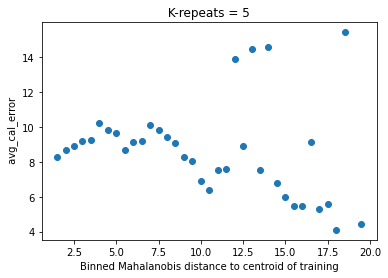

In [ ]:

plt.scatter(bin_distance, avg_cal_error)
plt.xlabel( "Binned Mahalanobis distance to centroid of training");
plt.ylabel( " avg_cal_error");
plt.title(' K-repeats = 5 ');

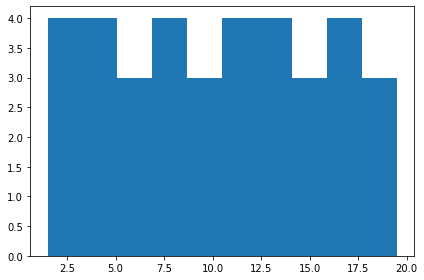

In [ ]:
plt.hist(bin_distance);

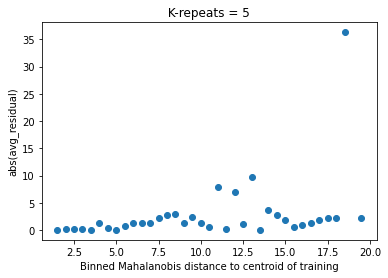

In [ ]:
plt.scatter(bin_distance,[ abs(x) for x in avg_residual])
plt.xlabel( "Binned Mahalanobis distance to centroid of training");
plt.ylabel( "abs(avg_residual)");
plt.title(' K-repeats = 5 ');

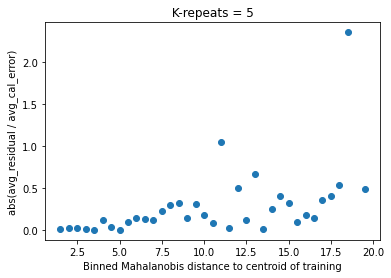

In [ ]:
plt.scatter(bin_distance, abs(np.array(avg_residual)/np.array(avg_cal_error)));
plt.xlabel( "Binned Mahalanobis distance to centroid of training");
plt.ylabel( "abs(avg_residual / avg_cal_error)");
plt.title(' K-repeats = 5 ');

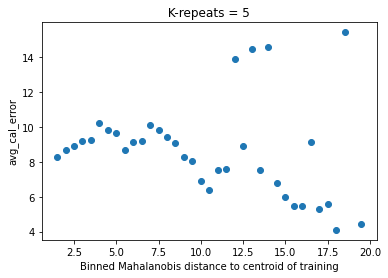

In [ ]:
plt.scatter(bin_distance, avg_cal_error);
plt.xlabel( "Binned Mahalanobis distance to centroid of training");
plt.ylabel( "avg_cal_error");
plt.title(' K-repeats = 5 ');

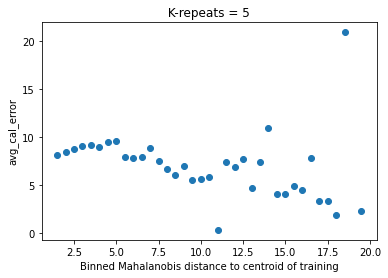

In [ ]:
plt.scatter(bin_distance,abs( np.array(avg_cal_error)- abs(np.array(avg_residual))));
plt.xlabel( "Binned Mahalanobis distance to centroid of training");
plt.ylabel( "abs(avg_cal_error - abs(avg_residual))");
plt.title(' K-repeats = 5 ');

In [ ]:
merged_df = pd.read_csv('/content/merged_K_5_supercon_test_hdbscan.csv', index_col=0)

In [ ]:
merged_df

,GSenergy_pa_composition_average,BulkModulus_difference,NUnfilled_composition_average,Density_min_value,valence_composition_average,HHIr_composition_average,IsAlkalineEarth_composition_average,Density_arithmetic_average,BCCvolume_padiff_composition_average,HHIp_composition_average,ElectronAffinity_composition_average,NfUnfilled_composition_average,IsRareEarth_composition_average,IsHexagonal_composition_average,ThermalConductivity_composition_average,ElectricalConductivity_composition_average,IonicRadii_composition_average,Polarizability_min_value,NValance_composition_average,ElasticModulus_composition_average,AtomicRadii_composition_average,BCCmagmom_composition_average,BCCfermi_composition_average,NfUnfilled_max_value,BCCenergy_pa_composition_average,model_error,residuals,maha_distance,split
536,-3.952519,123.0,2.100231,1.4290,2.131072,1638.781804,0.177332,4903.904833,-1.219834,2283.346184,66.867155,0.000000,0.000000,0.131072,71.631748,11.383963,1.259985,0.802000,7.518890,26.320740,1.195998,0.000000,3.418751,0,-2.702807,17.568789,-22.138667,2.358636,0
5478,-4.078618,123.0,1.902344,1.4290,2.423177,1772.786458,0.162760,4558.904833,-1.558040,2163.411458,79.570052,0.000000,0.000000,0.032552,60.913767,9.749349,1.220964,0.400000,8.897135,25.305990,1.188073,0.000000,3.767150,0,-2.807925,17.914846,-8.037300,2.855379,0
5479,-4.096669,112.0,2.052863,1.4290,2.563877,2001.321586,0.140969,5495.485800,-1.693767,2281.497797,86.826872,0.000000,0.035242,0.035242,37.840175,6.278414,1.247577,0.400000,9.823789,20.792952,1.189806,0.000028,4.111796,0,-2.789086,18.034468,25.957333,3.668361,0
5480,-3.867100,123.0,1.578947,1.4290,2.263158,1384.210526,0.210526,5703.571500,-1.341579,1789.473684,70.415789,0.000000,0.000000,0.000000,87.152842,13.705263,1.206842,0.400000,8.315789,26.210526,1.201263,0.000000,3.676326,0,-2.642881,7.722344,1.960500,2.611545,0
3639,-4.039364,123.0,1.966667,1.4290,2.366667,1523.333333,0.166667,5527.632714,-1.362833,2030.000000,78.093333,0.000000,0.000000,0.033333,64.197947,10.243333,1.227333,0.400000,8.900000,24.980000,1.202400,0.000000,3.773154,0,-2.795440,16.321162,-34.103000,2.823069,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,-4.131597,130.4,1.977176,1.4290,2.091295,1175.583147,0.136943,4865.571500,-0.964471,1956.155567,96.388264,0.045648,0.091295,0.091295,103.728668,15.695896,1.205085,0.802000,6.570594,35.536586,1.149683,0.000055,3.552631,2,-2.861265,14.787656,4.827378,2.066748,4
492,-4.207481,130.4,1.933524,1.4290,2.066476,1144.818188,0.132952,4225.857250,-0.935407,1743.103104,99.984531,0.000000,0.000000,0.066476,110.360347,16.632321,1.199242,0.802000,6.598285,38.981586,1.145609,0.000000,3.235176,0,-2.961023,6.665653,-8.184000,3.013061,4
472,-4.142874,130.4,1.934153,0.0899,2.006512,1096.599132,0.144718,3380.703780,-1.118669,1740.593343,93.498480,0.000000,0.000000,0.138205,91.100789,13.712012,1.239175,0.666793,5.960203,33.458755,1.115738,0.000000,3.164665,0,-2.898443,10.365939,-3.906049,2.975672,4
6080,-4.233277,139.0,2.047244,1.4290,2.102362,1323.622047,0.157480,4984.685800,-1.124567,2110.236220,74.785827,0.000000,0.000000,0.102362,89.665479,14.256693,1.187874,0.802000,6.267717,38.708661,1.167520,0.039780,3.221309,0,-3.000499,6.910154,8.315167,2.576541,4


In [ ]:
merged_df['rmse'] = (np.array(merged_df['residuals'])**2)**(1/2)

In [ ]:
merged_df

,GSenergy_pa_composition_average,BulkModulus_difference,NUnfilled_composition_average,Density_min_value,valence_composition_average,HHIr_composition_average,IsAlkalineEarth_composition_average,Density_arithmetic_average,BCCvolume_padiff_composition_average,HHIp_composition_average,ElectronAffinity_composition_average,NfUnfilled_composition_average,IsRareEarth_composition_average,IsHexagonal_composition_average,ThermalConductivity_composition_average,ElectricalConductivity_composition_average,IonicRadii_composition_average,Polarizability_min_value,NValance_composition_average,ElasticModulus_composition_average,AtomicRadii_composition_average,BCCmagmom_composition_average,BCCfermi_composition_average,NfUnfilled_max_value,BCCenergy_pa_composition_average,model_error,residuals,maha_distance,split,rmse
536,-3.952519,123.0,2.100231,1.4290,2.131072,1638.781804,0.177332,4903.904833,-1.219834,2283.346184,66.867155,0.000000,0.000000,0.131072,71.631748,11.383963,1.259985,0.802000,7.518890,26.320740,1.195998,0.000000,3.418751,0,-2.702807,17.568789,-22.138667,2.358636,0,22.138667
5478,-4.078618,123.0,1.902344,1.4290,2.423177,1772.786458,0.162760,4558.904833,-1.558040,2163.411458,79.570052,0.000000,0.000000,0.032552,60.913767,9.749349,1.220964,0.400000,8.897135,25.305990,1.188073,0.000000,3.767150,0,-2.807925,17.914846,-8.037300,2.855379,0,8.037300
5479,-4.096669,112.0,2.052863,1.4290,2.563877,2001.321586,0.140969,5495.485800,-1.693767,2281.497797,86.826872,0.000000,0.035242,0.035242,37.840175,6.278414,1.247577,0.400000,9.823789,20.792952,1.189806,0.000028,4.111796,0,-2.789086,18.034468,25.957333,3.668361,0,25.957333
5480,-3.867100,123.0,1.578947,1.4290,2.263158,1384.210526,0.210526,5703.571500,-1.341579,1789.473684,70.415789,0.000000,0.000000,0.000000,87.152842,13.705263,1.206842,0.400000,8.315789,26.210526,1.201263,0.000000,3.676326,0,-2.642881,7.722344,1.960500,2.611545,0,1.960500
3639,-4.039364,123.0,1.966667,1.4290,2.366667,1523.333333,0.166667,5527.632714,-1.362833,2030.000000,78.093333,0.000000,0.000000,0.033333,64.197947,10.243333,1.227333,0.400000,8.900000,24.980000,1.202400,0.000000,3.773154,0,-2.795440,16.321162,-34.103000,2.823069,0,34.103000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,-4.131597,130.4,1.977176,1.4290,2.091295,1175.583147,0.136943,4865.571500,-0.964471,1956.155567,96.388264,0.045648,0.091295,0.091295,103.728668,15.695896,1.205085,0.802000,6.570594,35.536586,1.149683,0.000055,3.552631,2,-2.861265,14.787656,4.827378,2.066748,4,4.827378
492,-4.207481,130.4,1.933524,1.4290,2.066476,1144.818188,0.132952,4225.857250,-0.935407,1743.103104,99.984531,0.000000,0.000000,0.066476,110.360347,16.632321,1.199242,0.802000,6.598285,38.981586,1.145609,0.000000,3.235176,0,-2.961023,6.665653,-8.184000,3.013061,4,8.184000
472,-4.142874,130.4,1.934153,0.0899,2.006512,1096.599132,0.144718,3380.703780,-1.118669,1740.593343,93.498480,0.000000,0.000000,0.138205,91.100789,13.712012,1.239175,0.666793,5.960203,33.458755,1.115738,0.000000,3.164665,0,-2.898443,10.365939,-3.906049,2.975672,4,3.906049
6080,-4.233277,139.0,2.047244,1.4290,2.102362,1323.622047,0.157480,4984.685800,-1.124567,2110.236220,74.785827,0.000000,0.000000,0.102362,89.665479,14.256693,1.187874,0.802000,6.267717,38.708661,1.167520,0.039780,3.221309,0,-3.000499,6.910154,8.315167,2.576541,4,8.315167


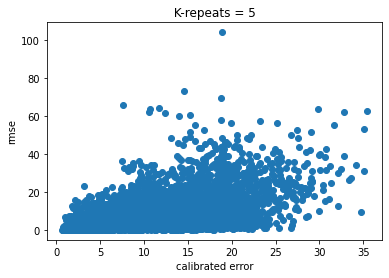

In [ ]:
plt.scatter(merged_df['model_error'], merged_df['rmse']);
plt.xlabel( "calibrated error");
plt.ylabel( "rmse");
plt.title(' K-repeats = 5.  superconductor dataset ');

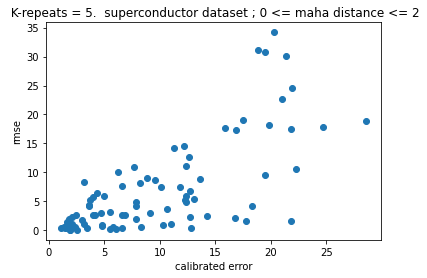

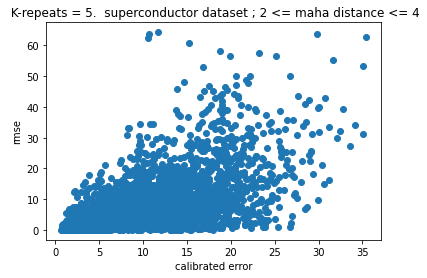

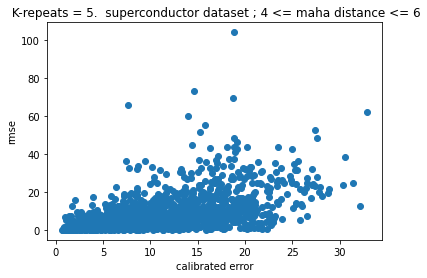

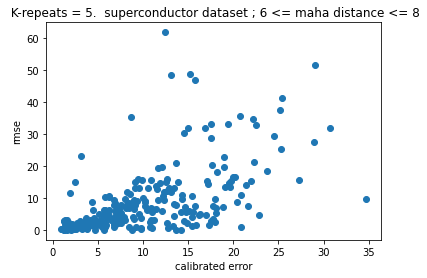

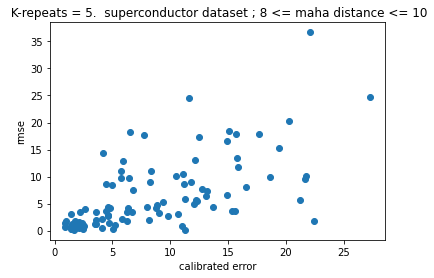

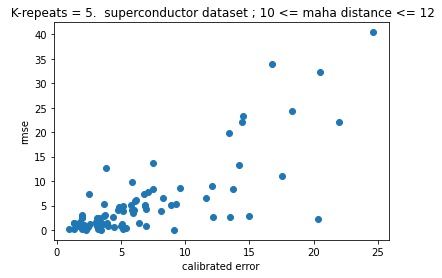

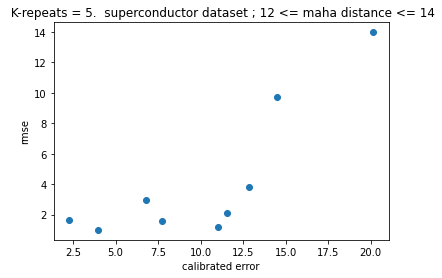

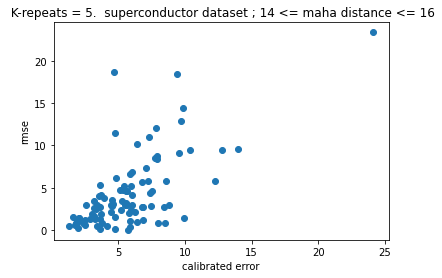

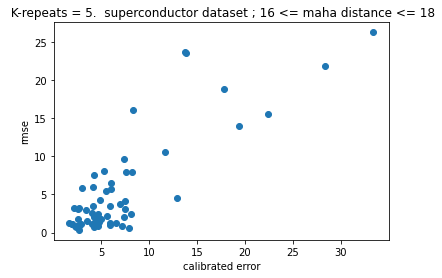

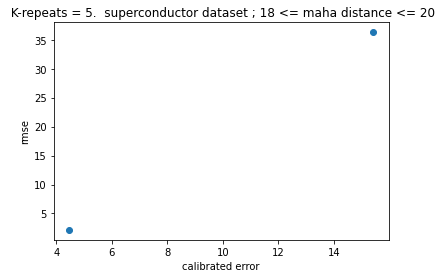

In [ ]:
K = 20
step = 2
for i in np.arange(0,K,step):
    maha_lower_bound = i
    maha_upper_bound = i+step
    subset_df  = merged_df.loc[(merged_df['maha_distance'] <= maha_upper_bound) &( merged_df['maha_distance'] >= maha_lower_bound)]
    plt.scatter(subset_df['model_error'], subset_df['rmse']);
    plt.xlabel( "calibrated error");
    plt.ylabel( "rmse");
    plt.title(' K-repeats = 5.  superconductor dataset ; {} <= maha distance <= {}'.format(maha_lower_bound, maha_upper_bound));
    plt.show()

,GSenergy_pa_composition_average,BulkModulus_difference,NUnfilled_composition_average,Density_min_value,valence_composition_average,HHIr_composition_average,IsAlkalineEarth_composition_average,Density_arithmetic_average,BCCvolume_padiff_composition_average,HHIp_composition_average,ElectronAffinity_composition_average,NfUnfilled_composition_average,IsRareEarth_composition_average,IsHexagonal_composition_average,ThermalConductivity_composition_average,ElectricalConductivity_composition_average,IonicRadii_composition_average,Polarizability_min_value,NValance_composition_average,ElasticModulus_composition_average,AtomicRadii_composition_average,BCCmagmom_composition_average,BCCfermi_composition_average,NfUnfilled_max_value,BCCenergy_pa_composition_average,model_error,residuals,maha_distance,split,rmse
536,-3.952519,123.0,2.100231,1.4290,2.131072,1638.781804,0.177332,4903.904833,-1.219834,2283.346184,66.867155,0.000000,0.000000,0.131072,71.631748,11.383963,1.259985,0.802000,7.518890,26.320740,1.195998,0.000000,3.418751,0,-2.702807,17.568789,-22.138667,2.358636,0,22.138667
5478,-4.078618,123.0,1.902344,1.4290,2.423177,1772.786458,0.162760,4558.904833,-1.558040,2163.411458,79.570052,0.000000,0.000000,0.032552,60.913767,9.749349,1.220964,0.400000,8.897135,25.305990,1.188073,0.000000,3.767150,0,-2.807925,17.914846,-8.037300,2.855379,0,8.037300
5480,-3.867100,123.0,1.578947,1.4290,2.263158,1384.210526,0.210526,5703.571500,-1.341579,1789.473684,70.415789,0.000000,0.000000,0.000000,87.152842,13.705263,1.206842,0.400000,8.315789,26.210526,1.201263,0.000000,3.676326,0,-2.642881,7.722344,1.960500,2.611545,0,1.960500
3639,-4.039364,123.0,1.966667,1.4290,2.366667,1523.333333,0.166667,5527.632714,-1.362833,2030.000000,78.093333,0.000000,0.000000,0.033333,64.197947,10.243333,1.227333,0.400000,8.900000,24.980000,1.202400,0.000000,3.773154,0,-2.795440,16.321162,-34.103000,2.823069,0,34.103000
3633,-3.799305,123.0,1.515789,1.4290,2.273684,1565.263158,0.210526,4889.017857,-1.433487,1911.578947,75.334211,0.000000,0.000000,0.000000,86.135961,13.561579,1.199105,0.400000,8.378947,26.726316,1.199158,0.000000,3.559564,0,-2.611456,2.291998,-0.388056,2.431854,0,0.388056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,-4.235484,130.4,2.097072,1.4290,2.087827,1178.890601,0.143297,4609.885800,-0.933309,1926.040062,96.306471,0.000000,0.010786,0.087827,96.932238,14.589676,1.216148,0.802000,6.318952,36.023112,1.165746,0.000009,3.226918,0,-2.980524,11.677644,-24.508000,2.476499,4,24.508000
30,-4.131597,130.4,1.977176,1.4290,2.091295,1175.583147,0.136943,4865.571500,-0.964471,1956.155567,96.388264,0.045648,0.091295,0.091295,103.728668,15.695896,1.205085,0.802000,6.570594,35.536586,1.149683,0.000055,3.552631,2,-2.861265,14.787656,4.827378,2.066748,4,4.827378
472,-4.142874,130.4,1.934153,0.0899,2.006512,1096.599132,0.144718,3380.703780,-1.118669,1740.593343,93.498480,0.000000,0.000000,0.138205,91.100789,13.712012,1.239175,0.666793,5.960203,33.458755,1.115738,0.000000,3.164665,0,-2.898443,10.365939,-3.906049,2.975672,4,3.906049
6080,-4.233277,139.0,2.047244,1.4290,2.102362,1323.622047,0.157480,4984.685800,-1.124567,2110.236220,74.785827,0.000000,0.000000,0.102362,89.665479,14.256693,1.187874,0.802000,6.267717,38.708661,1.167520,0.039780,3.221309,0,-3.000499,6.910154,8.315167,2.576541,4,8.315167
